In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import

In [ ]:
import os
import sys
import glob
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

!pip install -qqq -U rich
!pip install -qqq kornia

!pip install -qqq ipywidgets
!pip install -qqq timm

import kornia
import timm
import rich
from rich.progress import track
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
!pip install -qqq torchmetrics
import torchmetrics
!pip install -qqq torchsummary
from torchsummary import summary
import torch.nn.functional as F
from torch import optim
from PIL import Image
from torchvision import transforms as T
from torchvision import models

import warnings
warnings.filterwarnings('ignore')

print(f'Pytorch version: {torch.__version__}')
print(f'Python version: P{sys.version}')


     |████████████████████████████████| 235 kB 7.9 MB/s 
     |████████████████████████████████| 51 kB 7.2 MB/s 
     |████████████████████████████████| 565 kB 10.5 MB/s 
     |████████████████████████████████| 1.6 MB 9.3 MB/s 
     |████████████████████████████████| 509 kB 7.4 MB/s 
     |████████████████████████████████| 419 kB 6.8 MB/s 
Pytorch version: 1.12.1+cu113
Python version: P3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]


# Prepare

In [ ]:
img_size = 512
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img_transforms = T.Compose([
    T.Resize((img_size, img_size)),
    T.ToTensor()
])

In [ ]:
def load_img(img_fn):
    global device
    global img_transforms
    image = Image.open(img_fn)
    image = img_transforms(image)
    # to batch
    image = image.unsqueeze(0).to(device, torch.float)
    return image

def to_image(img_tensor):
    image = img_tensor.cpu().clone()
    image = image.squeeze(0)
    image = T.ToPILImage()(image)
    return image

def plot_img(img_tensor, title=None):
    image = to_image(img_tensor) if isinstance(content_img, torch.Tensor) else img_tensor
    plt.imshow(image)
    if title is not None:
        plt.title(title)

def plot_imgs(imgs, cols=3, size=7, title=['content img', 'style img1', 'style img1']):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        image = to_image(img) if isinstance(img, torch.Tensor) else img
        fig.add_subplot(rows, cols, i+1)
        plt.title(title[i])
        plt.imshow(image)
    plt.show()

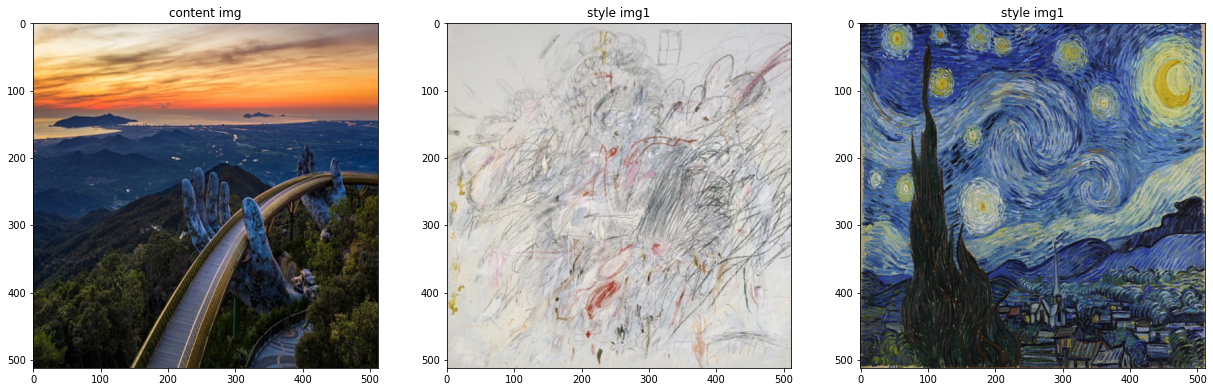

In [ ]:
content_img = load_img('/content/22-3cauvang_1616400590414.jpg') 
style_img1 = load_img('/content/photo-3-16443319476501860385717.jpg')
style_img2 = load_img('/content/The-Starry-Night.jpg')
plot_imgs([content_img, style_img1, style_img2])

# Define Loss Function

In [ ]:
class Normalization(nn.Module):
    def __init__(self):
        super(Normalization, self).__init__()
        self.mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).to(device)
        self.std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).to(device)

    def forward(self, image_tensor):
        return (image_tensor - self.mean) / self.std

class ContentLoss(nn.Module):
    def __init__(self, target_feature):
        super(ContentLoss, self).__init__()
        # target_feature is an constant, not variable     
        self.target_feature = target_feature.detach()

    def forward(self, input):
        self.loss = F.l1_loss(input, self.target_feature)
        return input


class StyleLoss(nn.Module):
  def __init__(self, target_feature):
    super().__init__()
    # Detach target since we do not want to use it for gradient computation.
    self._target = self._gram_matrix(target_feature.detach()).detach()

  def _gram_matrix(self, input):
    n, c, w, h = input.size()
    features = input.view(n * c, w * h)
    G = torch.mm(features, features.t())
    return G.div(n * c * w * h)

  def forward(self, input):
    G = self._gram_matrix(input)
    self.loss = F.l1_loss(G, self._target)
    return input

# def total_variation(img, reduction: str = "sum"):
#     pixel_dif1 = img[..., 1:, :] - img[..., :-1, :]
#     pixel_dif2 = img[..., :, 1:] - img[..., :, :-1]

#     res1 = pixel_dif1.abs()
#     res2 = pixel_dif2.abs()

#     reduce_axes = (-2, -1)
#     if reduction == "mean":
#         if img.is_floating_point():
#             res1 = res1.to(img).mean(dim=reduce_axes)
#             res2 = res2.to(img).mean(dim=reduce_axes)
#         else:
#             res1 = res1.float().mean(dim=reduce_axes)
#             res2 = res2.float().mean(dim=reduce_axes)
#     elif reduction == "sum":
#         res1 = res1.sum(dim=reduce_axes)
#         res2 = res2.sum(dim=reduce_axes)

#     return (res1 + res2).sum()/3

def total_variation(img, reduction: str = "sum"):
    if reduction == "sum":
      w_variance = torch.sum(torch.pow(img[:,:,:,:-1] - img[:,:,:,1:], 2))
      h_variance = torch.sum(torch.pow(img[:,:,:-1,:] - img[:,:,1:,:], 2))
    elif reduction == "mean":
      w_variance = torch.mean(torch.pow(img[:,:,:,:-1] - img[:,:,:,1:], 2))
      h_variance = torch.mean(torch.pow(img[:,:,:-1,:] - img[:,:,1:,:], 2))
    return (h_variance + w_variance)

# Pretrained Model (VGG19)

<img src='https://www.researchgate.net/profile/Clifford-Yang/publication/325137356/figure/fig2/AS:670371271413777@1536840374533/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means.jpg' />

In [ ]:
cnn_model = models.vgg19(pretrained=True).features.to(device).eval()
content_layers = ['relu_10']
style_layers = ['relu_1', 'relu_3', 'relu_5', 'relu_9', 'relu_13']

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

# Build Style Transfer Model

In [ ]:
def build_ST_model(
    cnn_model,
    content_img, style_imgs,
    content_layers, style_layers):
    """Build a style_transfer model with specify style and content"""

    cnn_model.eval()
    ST_model = nn.Sequential(Normalization())
    content_losses, style_losses, last_layer = [], [], 0
    i, j = 0, 0

    for layer in cnn_model.children():
        j += 1
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'avg_pool_{}'.format(i)
            layer = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)

        ST_model.add_module(name=name, module=layer)

        if name in content_layers:
            target_feature = ST_model(content_img)
            c_loss = ContentLoss(target_feature=target_feature)
            ST_model.add_module(f'content_loss_{i}', module=c_loss)
            content_losses.append(c_loss)
            last_layer = j

        if name in style_layers:
            for k, style_img in enumerate(style_imgs):
                target_feature = ST_model(style_img)
                s_loss = StyleLoss(target_feature=target_feature)
                ST_model.add_module(f'style_loss_{i+k}', module=s_loss)
                style_losses.append(s_loss)
                last_layer = j+1

    last_layer += len(content_losses) + len(style_losses)
    ST_model = ST_model[:last_layer]

    return ST_model, content_losses, style_losses

ST_model, content_losses, style_losses = build_ST_model(
                                        cnn_model, content_img, [style_img1],
                                        content_layers, style_layers)

In [ ]:
ST_model

Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1): ReLU()
  (style_loss_1): StyleLoss()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2): ReLU()
  (avg_pool_2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3): ReLU()
  (style_loss_3): StyleLoss()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_4): ReLU()
  (avg_pool_4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_5): ReLU()
  (style_loss_5): StyleLoss()
  (conv_6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_6): ReLU()
  (conv_7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_7): ReLU()
  (conv_8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), 

# Run Style Transfer Model

In [ ]:
def run_style_transfer(
    cnn_model, 
    content_img, 
    style_imgs, 
    content_layers,
    style_layers,
    input_img=None, 
    total_variation_weight=1e-5,
    num_steps=512, 
    content_weight=1., 
    style_weight=1e9,
    log_steps=50):

  model, content_losses, style_losses = build_ST_model(cnn_model, content_img, style_imgs, 
                                                       content_layers, style_layers)
  
  n, c, h, w = content_img.data.size()
  if input_img is None:
    input_img = torch.randn((n, c, h, w), device=device)
    input_img = input_img * .01  # Scale the noise variance down.

  optimizer = optim.Adam([input_img.requires_grad_()], lr=.05)

  transform = nn.Sequential(
    kornia.augmentation.RandomResizedCrop(
        size=(h, w), scale=(.97, 1.), ratio=(.97, 1.03)),
        kornia.augmentation.RandomRotation(degrees=1.))
  
  for step in track(range(num_steps)):
    input_img.data.clamp_(0, 1)
    optimizer.zero_grad()
    content_loss, style_loss = 0, 0
    model(input_img)

    for c_loss in content_losses:
        content_loss += c_loss.loss

    for s_loss in style_losses:
        style_loss += s_loss.loss

    total_loss = content_loss*content_weight + style_loss*style_weight
    total_loss += total_variation_weight * total_variation(input_img, reduction='sum')
    total_loss.backward()
    optimizer.step()
    
    if (step > 0 and step % log_steps == 0) or (step + 1) == num_steps:
      print(f'[{step}]:content_loss={content_loss.item()},'
            f' style_loss={style_loss.item():4f}')
      plt.figure(figsize=(10, 10))
      plt.imshow(input_img.data.clamp_(0, 1).squeeze(0).permute(1, 2, 0).data.cpu().numpy())
  return input_img

In [ ]:
inp = output

In [ ]:
# NOTE(eugenhotaj): It's unclear from Gatys et al. whether to use the outputs of
# the conv layer or the (ReLU) activations. We use the latter here as ad-hoc
# experiments did not show a difference in quality, although the loss seems to
# be a lot higher when using the conv layer outputs.
vgg_default_content_layers = ['relu_10']
vgg_default_style_layers = ['relu_1', 'relu_3', 'relu_5', 'relu_9', 'relu_13']

# Uncomment one of the lines below to use as the input_img to optimize.
input_img = None
# input_img = content_img.clone()
# input_img = style_imgs[0].clone()

output = run_style_transfer( 
    # Note(eugenhotaj): Gatys et al. use conv4_2 as the content layer. However,
    # we found that relu3_2 produces more visually appealing results.
    cnn_model, 
    content_img, 
    [style_img2], 
    content_layers=['relu_6'],
    style_layers=vgg_default_style_layers,
    input_img=inp4, 
    total_variation_weight=1e-5,
    num_steps=2000, 
    content_weight=1, 
    style_weight=2000,
    log_steps=250)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# save file from colab to driver
# ! cp -r '/content/8e-05_sum.png' '/content/drive/MyDrive/Colab Notebooks/style_transfer_img'

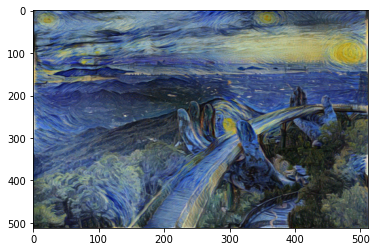

In [ ]:
plt.imshow(inp6.data.cpu().squeeze(0).permute(1,2,0), aspect='auto')
plt.savefig('image1.png')

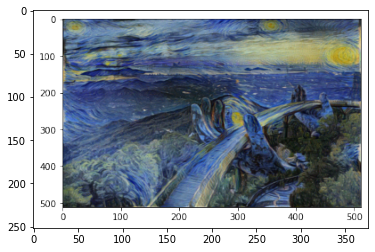

In [ ]:
img = plt.imread('/content/tải xuống.png')
plt.imshow(img, aspect='auto')
# plt.axis('off')
# plt.show()
# plt.savefig('image.png')

# Visualize Results

In [ ]:
path = 'style_transfer_img/'
file_paths = glob.glob(path + '*.png')
def get_path_img(file_paths, reduction_tv='sum'):
  tv_weight = set()
  list_img = []
  for i in file_paths:
    tv_weight.add(float(i.split('/')[1].split('_')[0]))
  tv_weight = sorted(tv_weight)
  for i in tv_weight:
    if i == 0.:
      list_img.append(load_img(path + str(int(i)) + '_' + '.png'))
    else:
      list_img.append(load_img(path + str(i) + '_' + reduction_tv + '.png'))
  return list_img, tv_weight
list_img, tv_weight = get_path_img(file_paths, reduction_tv='mean')

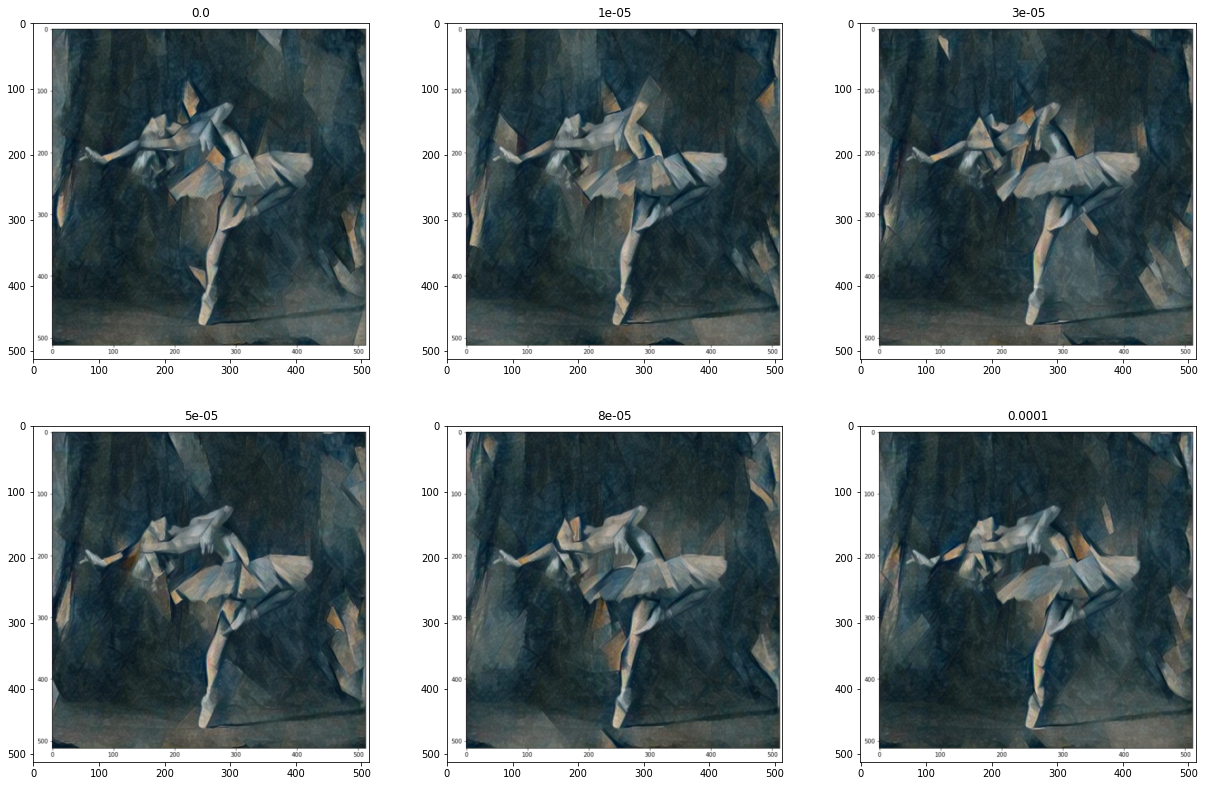

In [ ]:
# output with total variation (mean)
list_img, tv_weight = get_path_img(file_paths, reduction_tv='mean')
plot_imgs(list_img, title = tv_weight)

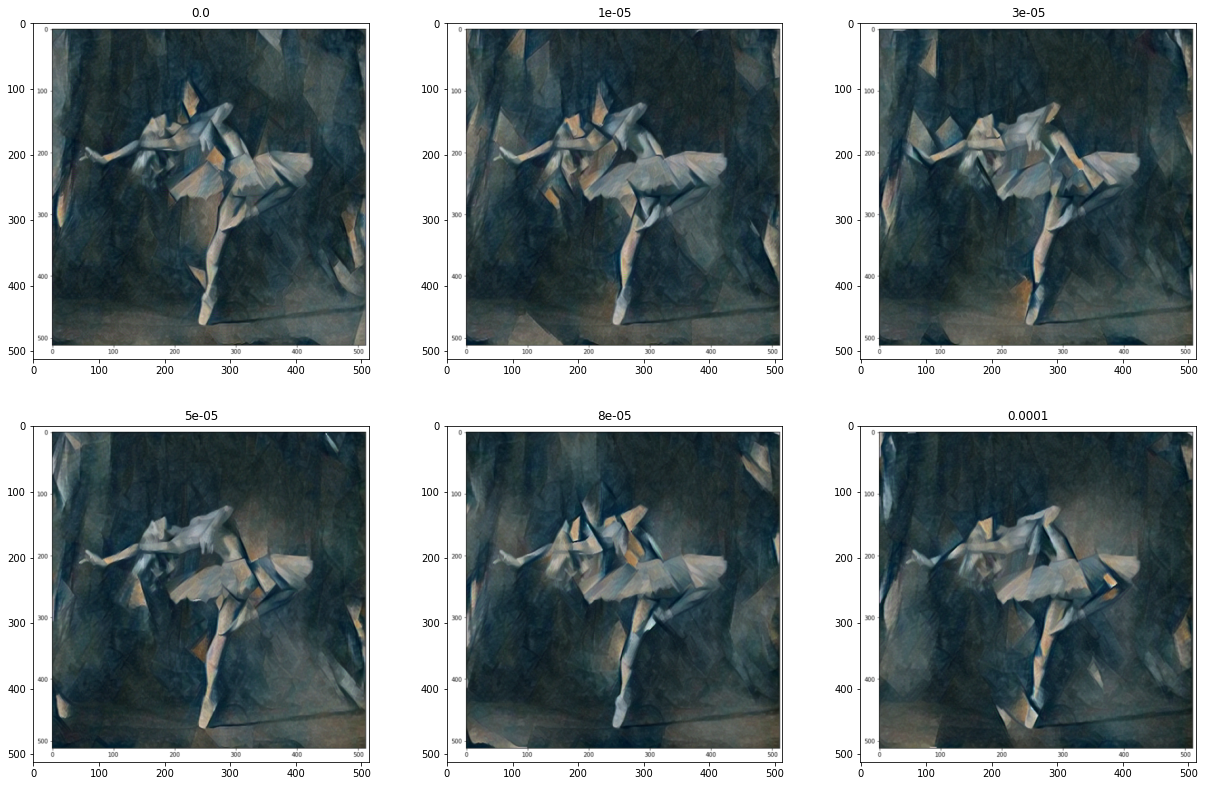

In [ ]:
# output with total variation (sum)
list_img, tv_weight = get_path_img(file_paths, reduction_tv='sum')
plot_imgs(list_img, title = tv_weight)